In [59]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt


class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(3, 6, 3, 1, 1)
        self.pool2 = nn.MaxPool2d(2)
        
        self.conv_trans1 = nn.ConvTranspose2d(6, 3, 4, 2, 1)
        self.conv_trans2 = nn.ConvTranspose2d(3, 1, 4, 2, 1)
        
    def forward(self, x):
        x = F.relu(self.pool1(self.conv1(x)))
        x = F.relu(self.pool2(self.conv2(x)))        
        x = F.relu(self.conv_trans1(x))
        x = self.conv_trans2(x)
        return x


In [2]:
dataset = datasets.MNIST(
    root='PATH',
    download=True,
    transform=transforms.ToTensor()
)
loader = DataLoader(
    dataset,
    num_workers=2,
    batch_size=8,
    shuffle=True
)


Extracting PATH/MNIST/raw/train-images-idx3-ubyte.gz to PATH/MNIST/raw


Extracting PATH/MNIST/raw/train-labels-idx1-ubyte.gz to PATH/MNIST/raw


Extracting PATH/MNIST/raw/t10k-images-idx3-ubyte.gz to PATH/MNIST/raw



Extracting PATH/MNIST/raw/t10k-labels-idx1-ubyte.gz to PATH/MNIST/raw
Processing...
Done!


/home/lukas/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729009598/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [60]:
model = MyModel()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 1
for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()
        
        if batch_idx % 1000 == 0:
            print('Epoch {}, Batch idx {}, loss {}'.format(epoch, batch_idx, loss.item()))

Epoch 0, Batch idx 0, loss 0.6677916646003723
Epoch 0, Batch idx 1000, loss 0.1362193375825882
Epoch 0, Batch idx 2000, loss 0.11266778409481049
Epoch 0, Batch idx 3000, loss 0.10619065165519714
Epoch 0, Batch idx 4000, loss 0.09194149076938629
Epoch 0, Batch idx 5000, loss 0.09108807146549225
Epoch 0, Batch idx 6000, loss 0.10190878063440323
Epoch 0, Batch idx 7000, loss 0.08688386529684067


In [4]:
def normalize_output(img):
    img = img - img.min()
    img = img / img.max()
    return img

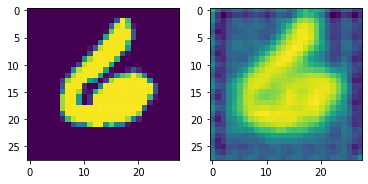

In [61]:
# Plot some images
idx = torch.randint(0, output.size(0), ())
pred = normalize_output(output[idx, 0])
img = data[idx, 0]
img_data = img.detach().numpy()
fig, axarr = plt.subplots(1, 2)
axarr[0].imshow(img_data)
axarr[1].imshow(pred.detach().numpy())

In [26]:
# Visualize feature maps
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [90]:
model.conv1.register_forward_hook(get_activation('conv1'))
model.conv2.register_forward_hook(get_activation('conv2'))
model.conv_trans1.register_forward_hook(get_activation('conv_trans1'))
model.conv_trans2.register_forward_hook(get_activation('conv_trans2'))

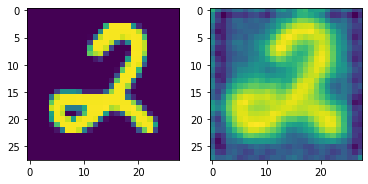

In [108]:
data, _ = dataset[torch.randint(0, len(dataset), ())]
data.unsqueeze_(0)
output = model(data)

fig, axarr = plt.subplots(1, 2)
axarr[0].imshow(data.squeeze().detach().numpy())
axarr[1].imshow(output.squeeze().detach().numpy())

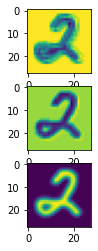

In [109]:
act = activation['conv1'].squeeze()
fig, axarr = plt.subplots(act.size(0))
for idx in range(act.size(0)):
    axarr[idx].imshow(act[idx])

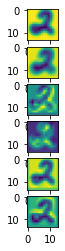

In [110]:
act = activation['conv2'].squeeze()
fig, axarr = plt.subplots(act.size(0))
for idx in range(act.size(0)):
    axarr[idx].imshow(act[idx])

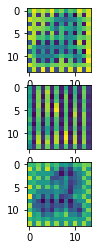

In [111]:
act = activation['conv_trans1'].squeeze()
fig, axarr = plt.subplots(act.size(0))
for idx in range(act.size(0)):
    axarr[idx].imshow(act[idx])

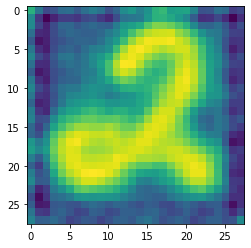

In [112]:
act = activation['conv_trans2'].squeeze()
fig, axarr = plt.subplots(1)
axarr.imshow(act)
    